# Linguistic variables
The goal of this notebook is to guide you through the exploration of the concept of linguistic variables in the context of fuzzy inference systems.
We will start by giving you an implementation of membership function which is general enough to define linguistic values of arbitrary shape. This implementation is slow, if you want to represent very complex and detailed membership functions; but can also be efficient if you use simpler membership functions (trapezoids).
Moreover, we will give you two implementations of linguistic variable. The former using a linguistic values without any constraint and therefore, limitating one of the advantages of fuzzy which is the interpretability. The second implementation adds some constraints to the shape of its linguistic values. They are implemented as trapezoids, with shared adjacent transition points.

In [5]:
import numpy as np
import matplotlib.pyplot as pl

%matplotlib inline

----------------------------

## Define a free-shaped membership function
This implementation allows the creation of membership functions of arbitrary shapes. Thus, a membership function is defined by specifying some points over it, and interpolation is used to evaluate its whole domain. Using this approach you can create membership functions from highly complex ones where the whole domain is defined explicitly (e.g., hand-crafted membership functions, functions like Gaussians or Sigmoids) to very simple ones like triangles of trapezoids.

In [55]:
class FreeShapeMF:
    """
    This class implements a membership function with free shape.
    The shape of the function is defined by giving a vector of input values
    and a the vector of corresponding membership values.
    Calling this class with a float number as parameter returns the
    degree of activation of the membership function for that value computed
    using interpolations between the two nearest known values.
    """
    def __init__(self, input_values, membership_values):
        """
        Two parameters needed:
        input_values: vector of input values
        membership_values: vector of membership values
        """
        assert len(input_values) == len(membership_values)
        for i in np.arange(1, len(input_values)):
            assert input_values[i-1] <= input_values[i]
        self.input_values = input_values
        self.membership_values = membership_values
        
    def __call__(self, value):
        if value <= self.input_values[0]:
            return self.membership_values[0]
        elif value >= self.input_values[-1]:
            return self.membership_values[-1]
        else:
            i = 1
            while value > self.input_values[i]:
                i = i + 1
            i_p = (value - self.input_values[i-1]) / float(self.input_values[i] - self.input_values[i-1])
            return i_p * (self.membership_values[i] - self.membership_values[i-1]) + self.membership_values[i-1]
    
    def apply_to(self, input_values):
        return map(self, input_values)
    
    def plot(self, input_values, col=None, name=None):
        output_values = self.apply_to(input_values)
        if col:
            pl.plot(input_values, output_values, c=col, label=name)
        else:
            pl.plot(input_values, output_values, label=name)
        pl.ylim(0, 1.05)
        pl.grid(True)

### Example of hand-crafted membership function

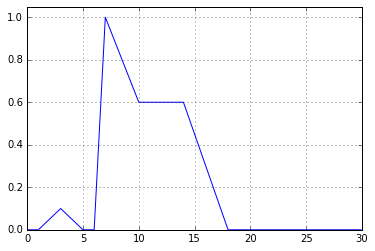

In [56]:
hand_crafted = FreeShapeMF([1.0, 3.0, 5.0, 6.0, 7.0, 10.0, 14.0, 18.0], [0.0, 0.1, 0.0, 0.0, 1.0, 0.6, 0.6, 0.0])
hand_crafted.plot(np.arange(0, 30, 0.1))

### Example of a trapezoidal membership function

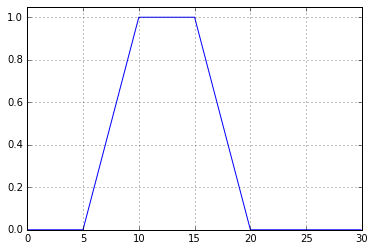

In [57]:
trapezoidal = FreeShapeMF([5.0, 10.0, 15.0, 20.0], [0.0, 1.0, 1.0, 0.0])
trapezoidal.plot(np.arange(0, 30, 0.1))

----------------

## Defining some methods that are common to both implementations of linguistic variable
We define a base class with some methods that can be reused by derived classes.
In its implementation the membership functions are stored in a dictionary. This make possible to access them by name.

In [67]:
class LinguisticVariable:
    def __str__(self):
        to_return = self.name + '\n'
        for name, mf in self.membership_functions.iteritems():
            to_return += name + ': ' + str(zip(mf.input_values, mf.membership_values))  + '\n'
        return to_return
    
    def get_linguistic_value(self, name):
        assert name in self.level_names
        return self.membership_functions[name].apply_to(self.input_values)
    
    def plot_linguistic_value(self, name):
        assert name in self.level_names
        mf = self.membership_functions[name]
        mf.plot(self.input_values, name=name)
        if self.input_value:
            activation = mf(self.input_value)
            pl.plot([0, self.input_value, self.input_value, self.input_value], [activation, activation, 0, activation], 'k--')
        pl.ylim(0, 1.05)
        pl.legend(loc=7)
        pl.grid(True)
        pl.title(self.name)
        
    def plot(self):
        for name, mf in self.membership_functions.iteritems():
            mf.plot(self.input_values, name=name)
            if self.input_value:
                activation = mf(self.input_value)
                pl.plot([0, self.input_value, self.input_value, self.input_value], [activation, activation, 0, activation], 'k--')
        pl.ylim(0, 1.05)
        pl.legend(loc=7)
        pl.grid(True)
        pl.title(self.name)
    
    def fuzzify(self, value):
        self.input_value = value
        self.membership_values = dict()
        for name, mf in self.membership_functions.iteritems():
            self.membership_values[name] = mf(self.input_value)
        return self.membership_values

--------------------------------

## A linguistic variable without constraints in its linguistic values
Let's first explore an implementation of linguistic variable which can be initialized with linguisitic values of any shape. This implementation receives (among other parameters) a list of membership functions of type FreeShapeMF in order to initialize its linguistic values.

In [68]:
class NonConstrainedLinguisticVariable(LinguisticVariable):
    """
    This class implements a linguistic variable.
    Linguistic values are defined at initialization by specifying their membership functions.
    """
    def __init__(self, name, v_min, v_max, membership_functions, level_names=None, res=0.1):
        """
        Six parameters needed:
        name: name of the variable
        v_min: minimum value of the variable
        v_max: maximum value of the variable
        membership_functions: list of membership_functions defining the linguistic values
        level_names: optional, name, or list of names of the linguistic values
        res: resolution
        """
        self.name = name
        assert v_max > v_min
        assert v_min <= min([min(m_f.input_values) for m_f in membership_functions])
        assert v_max >= max([max(m_f.input_values) for m_f in membership_functions])
        self.v_min = v_min
        self.v_max = v_max
        self.resolution = res
        self.input_values = np.arange(self.v_min, self.v_max, self.resolution)
        self.__set_membership_functions(membership_functions, level_names)
        self.input_value = None
        self.membership_values = dict()
    
    def __set_membership_functions(self, membership_functions, level_names):
        if level_names is None:
            level_names = 'V_level_'
        if isinstance(level_names, str):
            level_names = [level_names]
        if (len(level_names) == 1):
            if not level_names[0].endswith('_level_'):
                level_names[0] += '_level_'
            level_names = [level_names[0] + str(i) for i in np.arange(len(self.membership_functions))]
        assert len(level_names) == len(membership_functions)
        self.level_names = level_names
        self.membership_functions = {level_names[i]:membership_functions[i] for i in np.arange(len(membership_functions))}

### An example of the NonConstrainedLinguisticVariable

Define the free-shaped membership functions

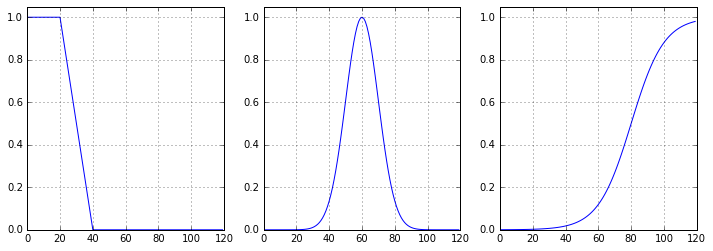

In [100]:
# Let's first define some basic functions
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def sigmoid(x, mu, sig):
    return 1 / (1 + np.exp(sig * (mu - x)))

# These are common constants
min_value = 0.0
max_value = 120.0
resolution = 1.0
input_values = np.arange(min_value, max_value, resolution)

# Definition of three linguistic values
slow = FreeShapeMF([20.0, 40.0], [1.0, 0.0])                        # Trapezoid
normal = FreeShapeMF(input_values, gaussian(input_values, 60.0, 10))# Gaussian
fast = FreeShapeMF(input_values, sigmoid(input_values, 80.0, 0.1))  # Sigmoid

# Plot them
pl.figure(figsize=(12,4))
pl.subplot(1,3,1)
slow.plot(input_values)
pl.subplot(1,3,2)
normal.plot(input_values)
pl.subplot(1,3,3)
fast.plot(input_values)

Define the linguistic variable using the linguistic values and constants created before

In [101]:
speed = NonConstrainedLinguisticVariable('Speed', min_value, max_value, [slow, normal, fast], ['slow', 'normal','fast'])

Notice that printing the linguistic variable gives us each one of the points that are defined in the functions  
These values can be more or less difficult to read deppending on the shape of the linguistic value  
- Observe the difference between slow and fast

In [102]:
print speed

Speed
slow: [(20.0, 1.0), (40.0, 0.0)]
fast: [(0.0, 0.00033535013046647811), (1.0, 0.00037060614062639654), (2.0, 0.00040956716498605005), (3.0, 0.00045262222324053502), (4.0, 0.00050020110707956389), (5.0, 0.00055277863692359955), (6.0, 0.00061087935943440102), (7.0, 0.00067508273063283746), (8.0, 0.00074602883383669699), (9.0, 0.00082442468639829457), (10.0, 0.00091105119440064539), (11.0, 0.0010067708200856369), (12.0, 0.0011125360328603205), (13.0, 0.0012293986212774202), (14.0, 0.0013585199504289581), (15.0, 0.0015011822567369917), (16.0, 0.0016588010801744215), (17.0, 0.0018329389424928035), (18.0, 0.0020253203890498819), (19.0, 0.0022378485212763317), (20.0, 0.0024726231566347743), (21.0, 0.0027319607630110591), (22.0, 0.0030184163247084215), (23.0, 0.0033348073074133443), (24.0, 0.0036842398994359859), (25.0, 0.0040701377158961277), (26.0, 0.0044962731609411782), (27.0, 0.0049668016500569569), (28.0, 0.0054862988994504036), (29.0, 0.0060598014915841103), (30.0, 0.00669285092428

The method "fuzzify" finds the degree of membership to each linguistic value for a given input value

In [103]:
speed.fuzzify(70)

{'fast': 0.2689414213699951, 'normal': 0.60653065971263342, 'slow': 0.0}

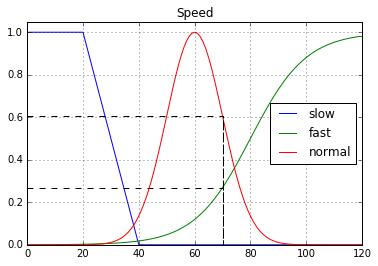

In [104]:
speed.plot()

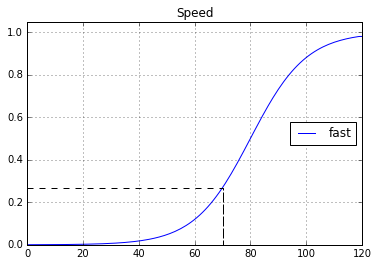

In [105]:
speed.plot_linguistic_value('fast')

----------------------------

## The interpretable linguistic variable
Now, let's explore an implementation of linguistic variable in which linguisitic values are constrained to have trapezoidal shapes and where transition points are shared between adjacent values. This implementation receives (among other parameters) a list of transition points from which membership functions of type FreeShapeMF are defined.

In [76]:
class InterpretableLinguisticVariable(LinguisticVariable):
    """
    This class implements a linguistic variable with some constraints
    in the definition in its membership functions.
    Linguistic values are shaped as trapezoidal membership functions,
    each membership function is defined by a a series of 2 or 4 points:
    
    1 _____p[0].  _ _ _ _ _ _      1 _ _ _  p[1].________.p[2] _ _ _ _temperature.fuzzify(19)
                \\                              /          \\
                 \\                            /            \\
                  \\                          /              \\
                   \\                        /                \\
    0 _ _ _ _ _ _ _ \\._______      0 _____./_ _ _ _ _ _ _ _ _ \\.______
                      p[1]                  p[0]                   p[3]
    
    Therefore, linguistic values are defined at initialization by specifying
    their transition points:
    
    1 _______   t[1]_______   t[3]__   t[5]______ . . .
             \\   /         \\   /    \\   / 
              \\ /           \\ /      \\ /
               X             X        X
              / \\           / \\      / \\
    0 _______/   \\_________/   \\____/   \\________ . . .
           t[0]          t[2]     t[4]
    
    """
    def __init__(self, name, v_min, v_max, transitions, level_names=None, res=0.1):
        """
        Four parameters needed:
        name: name of the variable
        v_min: minimum input value
        v_max: maximum input value
        transitions: list of values defining the starting and ending points of the linguistic values
        level_names: optional, name, or list of names of the linguistic values
        res: resolution
        """
        self.name = name
        assert v_min < v_max
        self.v_min = v_min
        self.v_max = v_max
        self.resolution = res
        self.input_values = np.arange(self.v_min, self.v_max, self.resolution)
        self.__set_transitions(transitions)
        self.__set_level_names(level_names)
        self.membership_functions = dict()
        self.membership_functions[self.level_names[0]] = FreeShapeMF([self.transitions[0], self.transitions[1]],
                                                                     [1.0,                 0.0])
        for i in np.arange(1, len(self.level_names) - 1):
            self.membership_functions[self.level_names[i]] = FreeShapeMF([self.transitions[(i*2) - 2],
                                                                          self.transitions[(i*2) - 1],
                                                                          self.transitions[(i*2) + 0],
                                                                          self.transitions[(i*2) + 1]],
                                                                         [0.0, 1.0, 1.0, 0.0])
        self.membership_functions[self.level_names[-1]] = FreeShapeMF([self.transitions[-2], self.transitions[-1]],
                                                                      [0.0,                  1.0])
        self.input_value = None
        self.membership_values = dict()

    def __set_transitions(self, transitions):
        n_transitions = len(transitions)
        assert n_transitions >= 2
        assert n_transitions % 2 == 0
        assert self.v_min <= transitions[0]
        assert transitions[-1] <= self.v_max
        for i in np.arange(1, n_transitions):
            assert transitions[i-1] <= transitions[i]
        self.transitions= transitions
    
    def __set_level_names(self, level_names):
        if level_names is None:
            level_names = 'V_level_'
        if isinstance(level_names, str):
            level_names = [level_names]
        if (len(level_names) == 1):
            if not level_names[0].endswith('_level_'):
                level_names[0] += '_level_'
            level_names = [level_names[0] + str(i) for i in np.arange((len(self.transitions) / 2) + 1)]
        assert len(level_names) == (len(self.transitions) / 2) + 1
        self.level_names = level_names

### An example of how to use the InterpretableLinguisticVariable
This linguistic variable is created with 4 transition points: 5, 10, 15, 20. The first two transition points are shared between the linguistic values low and medium. The two last transition points are shared between the linguistic values medium and high.

In [113]:
speed = InterpretableLinguisticVariable('Speed', 0, 120, [20,40,60,80], ['slow', 'normal','fast'], res=1.0)

Notice that, in this case, the results of printing the linguistic variable are much more easy to read and interpret

In [114]:
print speed

Speed
slow: [(20, 1.0), (40, 0.0)]
fast: [(60, 0.0), (80, 1.0)]
normal: [(20, 0.0), (40, 1.0), (60, 1.0), (80, 0.0)]



In [115]:
speed.fuzzify(70)

{'fast': 0.5, 'normal': 0.5, 'slow': 0.0}

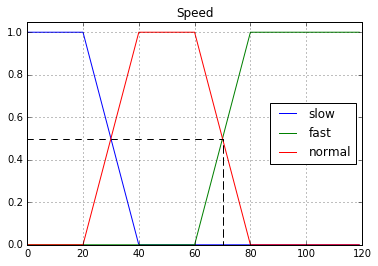

In [116]:
speed.plot()

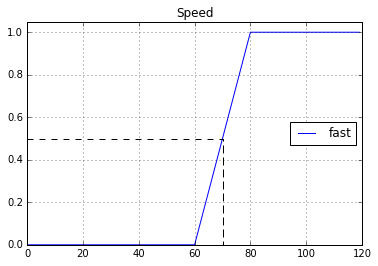

In [117]:
speed.plot_linguistic_value('fast')

-------------

## Exercise

Create linguistic variables for the three variables in the "tourist prediction problem":
- Temperature
- Sun
- Tourists